<a href="https://colab.research.google.com/github/akkiyolo/pytorch/blob/main/Handwritten_Digits_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Handwritten digits prediction (MNIST Dataset used)
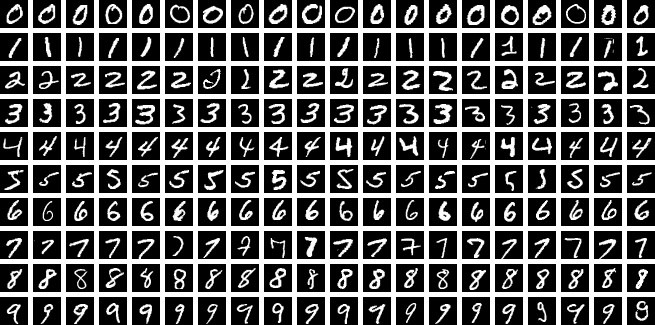

#### A complete deep learning project for recognizing handwritten digits using Convolutional Neural Networks.

In [2]:
## Importring required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu126
CUDA Available: False
Using device: cpu


#### Set Random Seeds for Reproducibility

In [3]:
## Set Random Seeds for Reproducibility
''' like for example :
Same results every time

(Without seed)
Run 1: 98.5% accuracy
Run 2: 98.9% accuracy
Run 3: 98.2% accuracy
(With seed)
Run 1: 98.7% accuracy
Run 2: 98.7% accuracy
Run 3: 98.7% accuracy
'''
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

#### Load and Prepare the Dataset

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of batches (train): {len(train_loader)}")
print(f"Number of batches (test): {len(test_loader)}")

Training samples: 60000
Test samples: 10000
Number of batches (train): 938
Number of batches (test): 157


#### Visualize Sample Images

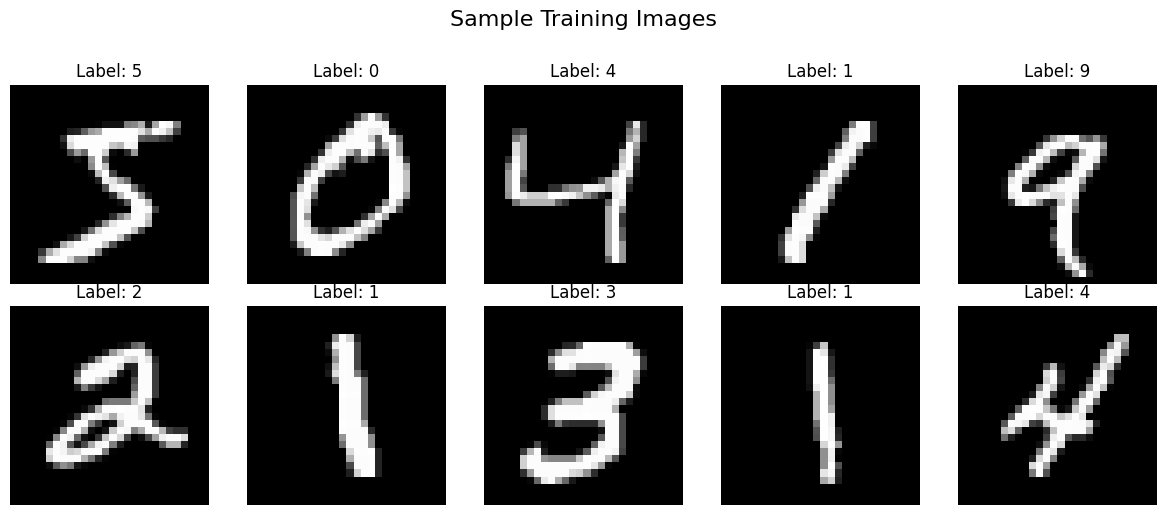

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.suptitle("Sample Training Images", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### Define the CNN model architecture

In [8]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14

        # Conv block 2
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7

        # Conv block 3
        x = self.pool(F.relu(self.conv3(x)))  # 7x7 -> 3x3

        # Flatten
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize model
model = DigitCNN().to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total Parameters: 422,026
Trainable Parameters: 422,026
